In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt 

In [2]:
# Load the KDD99 dataset
dataset = pd.read_csv("../dataset/kddcup.data/data.csv")

In [3]:
# Preprocess the data
def preprocess(df):
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    for col in categorical_columns:
        df[col] = df[col].astype('category').cat.codes
    # df.to_csv("../Preprocess/kddcup.data.csv")
    return df.values

df = preprocess(dataset)

In [4]:
# Split the data into training and test sets
train_data = df[:int(len(df) * 0.9)]
test_data = df[int(len(df) * 0.9):]

In [5]:
# Define the generator model
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(256, input_dim=100))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.BatchNormalization(momentum=0.8))
    model.add(tf.keras.layers.Dense(512))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.BatchNormalization(momentum=0.8))
    model.add(tf.keras.layers.Dense(1024))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.BatchNormalization(momentum=0.8))
    model.add(tf.keras.layers.Dense(np.prod(train_data.shape[1:]), activation='tanh'))
    model.add(tf.keras.layers.Reshape(target_shape=train_data.shape[1:]))
    return model

generator = make_generator_model()

In [6]:
# Define the discriminator model
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Flatten(input_shape=train_data.shape[1:]))
    model.add(tf.keras.layers.Dense(1024))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dense(512))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dense(256))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
    return model

discriminator = make_discriminator_model()

# Compile the discriminator
discriminator.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(0.0002, 0.5), metrics=['accuracy'])

# Freeze the weights of the discriminator
discriminator.trainable = False

In [7]:
# Define the combined model for training the generator
def make_gan(discriminator, generator):
    model = tf.keras.Sequential()
    model.add(generator)
    model.add(discriminator)
    return model

gan = make_gan(discriminator, generator)

# Compile the combined model
gan.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(0.0002, 0.5))

In [8]:
# Train the GAN
def train(gan, discriminator, generator, train_data, batch_size=128, epochs=100):
    half_batch = int(batch_size / 2)
    for epoch in range(epochs):
        # Train the discriminator
        idx = np.random.randint(0, train_data.shape[0], half_batch)
        real_data = train_data[idx]
        noise = np.random.normal(0, 1, (half_batch, 100))
        fake_data = generator.predict(noise)
        real_labels = np.ones((half_batch, 1))
        fake_labels = np.zeros((half_batch, 1))
        d_loss_real = discriminator.train_on_batch(real_data, real_labels)
        d_loss_fake = discriminator.train_on_batch(fake_data, fake_labels)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # Train the generator
        noise = np.random.normal(0, 1, (batch_size, 100))
        fake_labels = np.ones((batch_size, 1))
        g_loss = gan.train_on_batch(noise, fake_labels)

        # Print progress
        print("Epoch: %d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch + 1, d_loss[0], 100 * d_loss[1], g_loss))

train(gan, discriminator, generator, train_data, epochs=100)

2/2 [==============================] - 2s 0s/step
Epoch: 1 [D loss: 1.553238, acc.: 46.88%] [G loss: 0.671096]
2/2 [==============================] - 0s 9ms/step
Epoch: 2 [D loss: 0.353840, acc.: 63.28%] [G loss: 0.666811]
2/2 [==============================] - 0s 8ms/step
Epoch: 3 [D loss: 0.356504, acc.: 64.84%] [G loss: 0.670732]
2/2 [==============================] - 0s 0s/step
Epoch: 4 [D loss: 0.351277, acc.: 66.41%] [G loss: 0.674895]
2/2 [==============================] - 0s 8ms/step
Epoch: 5 [D loss: 0.345427, acc.: 77.34%] [G loss: 0.686369]
2/2 [==============================] - 0s 6ms/step
Epoch: 6 [D loss: 0.342965, acc.: 78.91%] [G loss: 0.697211]
2/2 [==============================] - 0s 0s/step
Epoch: 7 [D loss: 0.334972, acc.: 82.81%] [G loss: 0.715224]
2/2 [==============================] - 0s 0s/step
Epoch: 8 [D loss: 0.337574, acc.: 80.47%] [G loss: 0.726165]
2/2 [==============================] - 0s 8ms/step
Epoch: 9 [D loss: 0.330591, acc.: 84.38%] [G loss: 0.7553

In [9]:
# Generate new data
noise = np.random.normal(0, 1, (100, 100))
generated_data = generator.predict(noise)

4/4 [==============================] - 0s 5ms/step


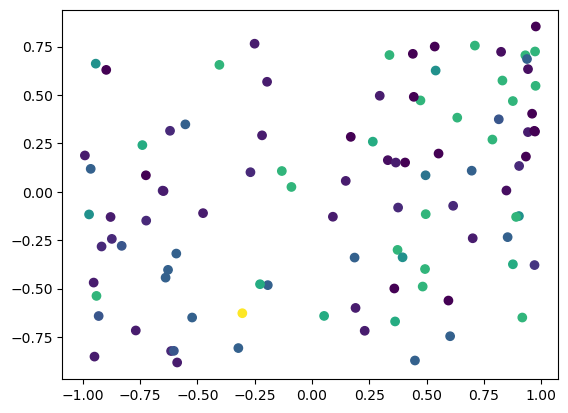

In [18]:
# Plot the generated data
plt.scatter(generated_data[:, 0], generated_data[:, 1], c=np.argmax(generated_data[:, 2:], axis=1))
plt.show()

In [11]:
# Save the discriminator model
discriminator.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(0.0002, 0.5))
discriminator.save('../ML/GAN/discriminator29.h5')

# Save the generator model
generator.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
generator.save('../ML/GAN/generator29.h5')

# Save the combined model
gan.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(0.0002, 0.5))
gan.save('../ML/GAN/gan29.h5')

In [12]:
# Load the discriminator model
loaded_discriminator = tf.keras.models.load_model('../ML/GAN/discriminator29.h5')

# Load the generator model
loaded_generator = tf.keras.models.load_model('../ML/GAN/generator29.h5')

# Load the combined model
loaded_gan = tf.keras.models.load_model('../ML/GAN/gan29.h5')

In [13]:
# Tensorflow Warning Fix
@tf.function(input_signature=(tf.TensorSpec(shape=[None], dtype=tf.int32),))
def next_collatz(x):
    print("Tracing with", x)
    return tf.where(x % 2 == 0, x // 2, 3 * x + 1)

In [14]:
honeypot_result = pd.read_csv("../honey.csv")

FileNotFoundError: [Errno 2] No such file or directory: '../honey.csv'

In [46]:
# Preprocess the data
def result_preprocess(honey_res):
    categorical_columns = [col for col in honey_res.columns if honey_res[col].dtype == 'object']
    for col in categorical_columns:
        honey_res[col] = honey_res[col].astype('category').cat.codes
    honey_res.to_csv("./realtime.csv")
    return honey_res.values

honey_res = result_preprocess(honeypot_result)

In [15]:
# Custom input data GAN
input_data = np.array([[0,35,0,0,3,722,2193,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]])
# input_data = np.array([[0,1,1,2,722,2193,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.10,0.11,0.12,0.13,0.14,0.15,0.16,0.17,0.18,0.19,0.20,0.21,1242352]])
# input_data = np.array([[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]])
# Make a prediction using the model
prediction_data = discriminator.predict(input_data)

print(prediction_data)

1/1 [==============================] - 0s 80ms/step
[[1.]]
